## Imports

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Load data

In [2]:
#Load data for CGAN
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
# Load data for classifier
mnist_classifier = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist_classifier.train.images, mnist_classifier.train.labels
X_validation, y_validation = mnist_classifier.validation.images, mnist_classifier.validation.labels
X_test, y_test             = mnist_classifier.test.images, mnist_classifier.test.labels

# set parameters for CGAN
Z_dim = 100
h_dim = 128

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

### Zero padding for classifer

In [0]:
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

## Placeholder

In [0]:
# CGAN
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

# Classifier
x_Classfier = tf.placeholder(tf.float32, (None, 32, 32, 1))
y_Classfier = tf.placeholder(tf.int32, (None))
one_hot_y_Classfier = tf.one_hot(y_Classfier, 10)

## Generator

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

Instructions for updating:
Colocations handled automatically by placer.


## Discriminator

In [0]:
D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

## Classifier

In [0]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Input: BATCH_SIZEx32x32x1
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    
    # Activation. max(0,conv1)
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # [Batch,Height,Width,Depth]
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits

## Set parameters for CGAN and classifier

In [0]:
# CGAN
mb_size = 64
# Now the learning rate is automatic
Rate_G = 0.00015
Rate_D = 0.00015

#Classifier
EPOCHS = 20
BATCH_SIZE = 128
Rate_C = 0.005

## Loss Function

In [9]:
# CGAN
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

# Classifier
logits = LeNet(x_Classfier)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y_Classfier, logits=logits)  
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=Rate_C)
# AdagradOptimizer, or MomentumOptimizer
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#Function to Evaluate Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [0]:
predictions_operation = tf.argmax(tf.nn.softmax(logits), 1)
correct_prediction = tf.equal(predictions_operation, tf.argmax(one_hot_y_Classfier, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    # i = 0:BATCH_SIZE:num_examples
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x_Classfier: batch_x, y_Classfier: batch_y})
        
        all_predictions = np.hstack((all_predictions, predictions))
        total_accuracy += (accuracy * len(batch_x))
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions

## Training Pipeline

In [12]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

num_examples = len(X_train) 
k = num_examples % BATCH_SIZE
num_examples = num_examples - k
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for it in range(100000):

        X_mb, y_mb = mnist.train.next_batch(mb_size)


        Z_sample = sample_Z(mb_size, Z_dim)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

        if it % 10000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}   G_loss: {:.4}'. format(D_loss_curr,G_loss_curr))
            print()
            
    num_examples = len(X_train)
    print("Training Classifier")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
         
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_Classfier: batch_x, y_Classfier: batch_y})
            
        validation_accuracy, validation_predictions = evaluate(X_validation, y_validation)
        if ((i+1)%10 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
    saver.save(sess, './lenet')
    print("Model saved")

Iter: 0
D loss: 1.208   G_loss: 2.759

Iter: 10000
D loss: 0.3689   G_loss: 4.747

Iter: 20000
D loss: 0.7206   G_loss: 2.376

Iter: 30000
D loss: 0.7359   G_loss: 1.92

Iter: 40000
D loss: 0.7211   G_loss: 1.791

Iter: 50000
D loss: 1.095   G_loss: 1.944

Iter: 60000
D loss: 0.7413   G_loss: 2.097

Iter: 70000
D loss: 0.7761   G_loss: 1.764

Iter: 80000
D loss: 0.7374   G_loss: 1.959

Iter: 90000
D loss: 0.751   G_loss: 1.776

Training Classifier
EPOCH 1 ...
Validation Accuracy = 0.980

EPOCH 10 ...
Validation Accuracy = 0.990

EPOCH 20 ...
Validation Accuracy = 0.987

Model saved


## Inception score

In [17]:
n_sample = 1000
y_generated = np.zeros(shape=[10*n_sample,y_dim])
y_ = np.zeros(shape=[10*n_sample])
Z_sample = sample_Z(10*n_sample, Z_dim)

for i in range(10):   
    y_generated[n_sample*i:n_sample*(i+1), i] = 1
    y_[n_sample*i:n_sample*(i+1)] = i


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_generated})
    x_generated = samples.reshape((10*n_sample,28, 28))
    x_generated = np.pad(x_generated, ((0,0),(2,2),(2,2)), 'constant')    
    x_ = np.zeros(shape=[10*n_sample,32,32,1])
    x_[:,:,:,0] = x_generated
    
    generated_accuracy, generated_predictions = evaluate(x_, y_)
    print("Accuracy of Generated Images = {:.3f}".format(generated_accuracy))
    
    test_accuracy, test_predictions = evaluate(X_test, y_test)
    print("Accuracy of Testing Set = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Accuracy of Generated Images = 0.943
Accuracy of Testing Set = 0.985


## Visualisations

INFO:tensorflow:Restoring parameters from ./lenet


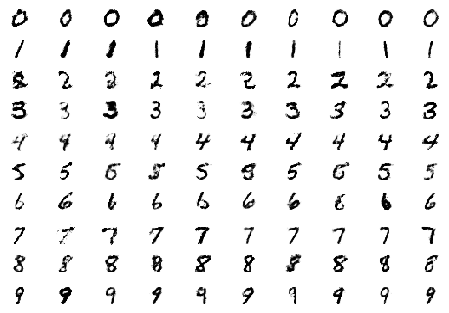

In [18]:
def plot_images(images):
    assert len(images) == 100
    img_shape = (28, 28)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(10, 10)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
            # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
     
n_sample = 10
samples = np.zeros(shape=[10, n_sample, 784])
images = np.zeros(shape=[100, 28, 28])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range(10):
        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, i] = 1
        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
        images[10*i:10*i+10] = samples.reshape((10,28, 28))
    
    
plot_images(images)

## Back up

In [0]:
'''
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

num_examples = len(X_train) 
k = num_examples % BATCH_SIZE
num_examples = num_examples - k
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCHS):                        
        X_train = shuffle(X_train)      
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch,label = X_train[offset:end],y_train[offset:end]
            #batch = np.array(batch).tolist()
            
            Z_sample = sample_Z(mb_size, Z_dim)
            
            d_ls = sess.run([D_loss], feed_dict={X: batch, Z: Z_sample, y:label})
            g_ls = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:label})
            
            if g_ls * 1.5 < d_ls:
                train_g = False
                pass
            if d_ls * 2 < g_ls:
                train_d = False
                pass
    
            if train_d:
                sess.run(D_solver, feed_dict={X: batch, Z: Z_sample, y:label})
                
            if train_g:
                sess.run(G_solver, feed_dict={Z: Z_sample, y:label})  
            #_, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: batch, Z: Z_sample, y:label})
            #_, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:label})            


        if ((i+1)%20 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print('D loss: {:.3f}'.format(D_loss_curr))
            print('G_loss: {:.3f}'.format(G_loss_curr))
            print()
    saver.save(sess, './lenet')
    print("Model saved")
    

    for it in range(50000):

        X_mb, y_mb = mnist.train.next_batch(mb_size)


        Z_sample = sample_Z(mb_size, Z_dim)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

        if it % 10000 == 0:
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'. format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()
'''